In [1]:
import numpy as np;
import nibabel as nb;
import glob
import matplotlib.pyplot as plt
from loguru import logger

In [2]:
def min_max_normalization(image):
        image = (image - image.min()) / (image.max() - image.min()) * 255
        return image

## Getting images from labels and patients folder

In [3]:
root_dir = '../../data_lab2/'

patients = glob.glob(root_dir+ 'patients/' + '*.nii.gz')

labels = glob.glob(root_dir + 'labels/'+ '*.nii.gz')

masks = glob.glob(root_dir + 'masks/' + '*.nii.gz')

original = glob.glob(root_dir + 'original/' + '*.nii.gz')

original_labels = glob.glob(root_dir + 'Labels_original/' + '*.nii.gz')

logger.success(f'Imported from folder {len(original)}')

brain_layer = 127
number_of_brains = 5
brain_to_graph = 0


patients =  [ nb.load(patients[i]).get_fdata() for i in range(number_of_brains) ]

patients = [ min_max_normalization(patients[i]) for i in range(number_of_brains)]

labels =  [ nb.load (labels[i]).get_fdata() for i in range(number_of_brains) ]

masks =  [ nb.load (masks[i]).get_fdata() for i in range(number_of_brains) ]

original =  [ nb.load (original[i]).get_fdata() for i in range(number_of_brains) ]

original_labels =  [ nb.load (original_labels[i]).get_fdata() for i in range(number_of_brains) ]

patients = np.stack(patients,axis=0)
labels = np.stack(labels,axis=0)
masks = np.stack(masks,axis=0)


patients = patients * masks


logger.success(f'Size of the images arrays {labels.shape,masks.shape,labels.shape}')


2023-11-05 16:45:58.037 | SUCCESS  | __main__:<module>:13 - Imported from folder 15
2023-11-05 16:46:06.198 | SUCCESS  | __main__:<module>:40 - Size of the images arrays ((5, 256, 261, 256), (5, 256, 261, 256), (5, 256, 261, 256))


## Creating the MEAN MAP

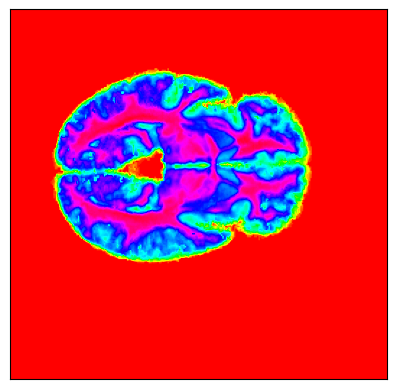

In [4]:
mean_map = np.mean(patients, axis=0)

plt.imshow(mean_map[:,:,brain_layer],cmap='hsv')
plt.yticks([])
plt.xticks([])
plt.show()

#File saving
nii_img = nb.Nifti1Image(mean_map, None)

# Specify the output file path with the .nii.gz extension
output_file = 'mean_map.nii.gz'

# Save the NIfTI image to a file
nii_img.to_filename(output_file)


In [5]:
white_matter_mask =  [ np.where(labels[i,:,:,:] == 3, 1, 0) for i in range(number_of_brains) ]
white_matter_mask = np.stack(white_matter_mask,axis=0)
white_matter = patients * white_matter_mask
prob_white_matter = np.sum(white_matter,axis=0)
prob_white_matter = ((prob_white_matter / np.max(prob_white_matter)) * 255 ).astype(int)

In [6]:
gray_matter_mask =  [ np.where(labels[i,:,:,:] == 2, 1, 0) for i in range(number_of_brains) ]
gray_matter_mask = np.stack(gray_matter_mask,axis=0)
gray_matter = patients * gray_matter_mask
prob_gray_matter = np.sum(gray_matter,axis=0)
prob_gray_matter = ((prob_gray_matter / np.max(prob_gray_matter)) * 255 ).astype(int)

In [7]:

cfs_matter_mask =  [ np.where(labels[i,:,:,:] == 1, 1, 0) for i in range(number_of_brains) ]
cfs_matter_mask = np.stack(cfs_matter_mask,axis=0)
cfs_matter = patients * cfs_matter_mask
prob_cfs_matter = np.sum(cfs_matter,axis=0)
prob_cfs_matter = ((prob_cfs_matter / np.max(prob_cfs_matter)) * 255 ).astype(int)

In [8]:
back_ground_mask =  [ np.where(labels[i,:,:,:] == 0, 1, 0) for i in range(number_of_brains) ]
back_ground_mask = np.stack(back_ground_mask,axis=0)
background = patients * back_ground_mask
prob_bk = np.sum(background,axis=0)

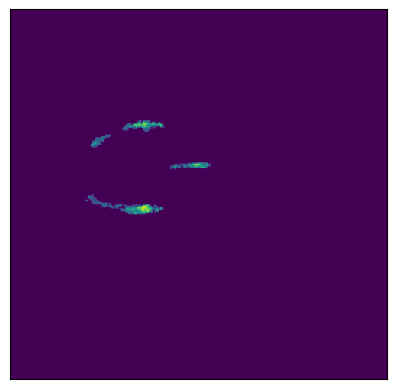

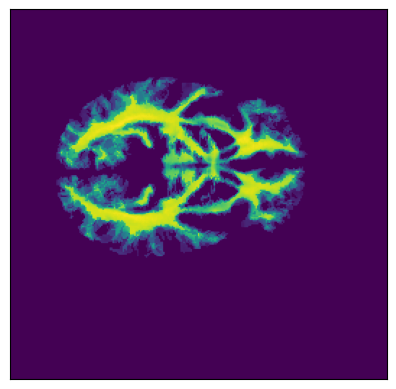

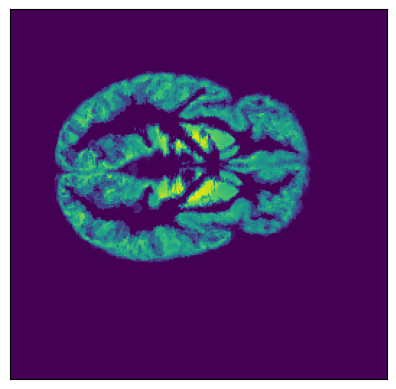

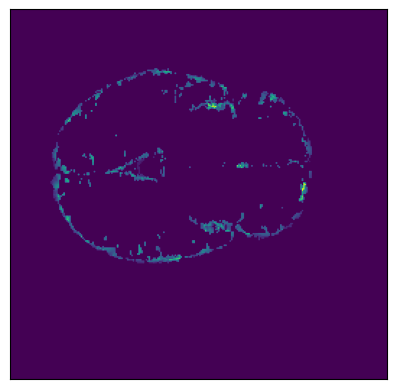

In [9]:
plt.imshow(prob_cfs_matter[:,:,brain_layer])
plt.yticks([])
plt.xticks([])
plt.figure()
plt.imshow(prob_gray_matter[:,:,brain_layer])
plt.yticks([])
plt.xticks([])
plt.figure()
plt.imshow(prob_white_matter[:,:,brain_layer])
plt.yticks([])
plt.xticks([])
plt.figure()
plt.imshow(prob_bk[:,:,brain_layer])
plt.yticks([])
plt.xticks([])

plt.show()

In [10]:
nii_img = nb.Nifti1Image(np.stack([prob_bk,prob_cfs_matter,prob_gray_matter,prob_white_matter],axis=0),None)

# Specify the output file path with the .nii.gz extension
output_file = 'atlas.nii.gz'

# Save the NIfTI image to a file
nii_img.to_filename(output_file)

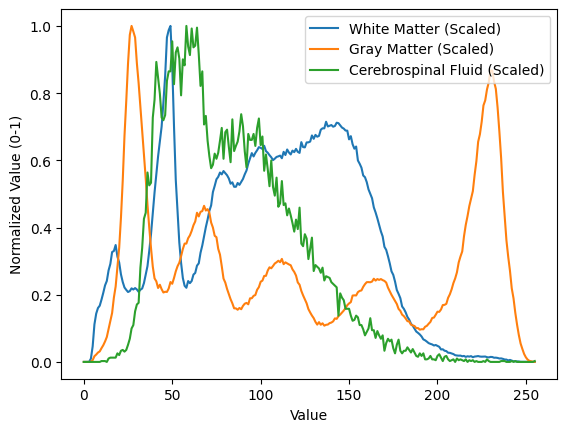

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Example histograms (replace with your own data)
hist_wm, _ = np.histogram(prob_white_matter[prob_white_matter != 0], range=(0, prob_white_matter[prob_white_matter != 0].max()), bins=prob_white_matter[prob_white_matter != 0].max() + 1)
hist_gm, _ = np.histogram(prob_gray_matter[prob_gray_matter != 0], range=(0, prob_gray_matter[prob_gray_matter != 0].max()), bins=prob_gray_matter[prob_gray_matter != 0].max() + 1)
hist_cfs, _ = np.histogram(prob_cfs_matter[prob_cfs_matter != 0], range=(0, prob_cfs_matter[prob_cfs_matter != 0].max()), bins=prob_cfs_matter[prob_cfs_matter != 0].max() + 1)

# Normalize histograms to represent probabilities
hist_wm_prob = hist_wm / hist_wm.sum()
hist_gm_prob = hist_gm / hist_gm.sum()
hist_cfs_prob = hist_cfs / hist_cfs.sum()

# Scale the probability normalized histograms to the [0, 1] range
def scale_to_0_1(hist):
    min_val = hist.min()
    max_val = hist.max()
    scaled_hist = (hist - min_val) / (max_val - min_val)
    return scaled_hist

hist_wm_scaled = scale_to_0_1(hist_wm_prob)
hist_gm_scaled = scale_to_0_1(hist_gm_prob)
hist_cfs_scaled = scale_to_0_1(hist_cfs_prob)

# Create x values for the histogram bins
x_values = np.arange(len(hist_wm_scaled))

# Calculate the x-coordinates of the bar centers
bar_centers = x_values

# Plot the scaled histograms
plt.plot(bar_centers, hist_wm_scaled,label='White Matter (Scaled)')
plt.plot(bar_centers, hist_gm_scaled,label='Gray Matter (Scaled)')
plt.plot(bar_centers, hist_cfs_scaled,label='Cerebrospinal Fluid (Scaled)')

# Set labels and legend
plt.xlabel('Value')
plt.ylabel('Normalized Value (0-1)')
plt.legend()

# Show the plot
plt.show()
